In [37]:
# train two clf on a dataset
# visualize decision boundary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.model_selection import cross_val_score


def plot_contour_pool(pool_, data, data_y):
  # Plotting decision regions #bricolage
  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                      np.arange(y_min, y_max, 0.01))
  colors_ = ['green', 'orange', 'red', 'blue', 'purple', 'yellow', 'pink', 'cyan', 'black', 'grey', 'lime']
  i = 0
  sns.scatterplot(x=data[:,0], y=data[:, 1], hue=data_y.reshape(int(data.shape[0])), alpha=0.2)
  for clf in pool_:
      Z = clf(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
      Z = (Z.detach() >= 0.5).int().numpy().reshape(xx.shape)
      plt.contour(xx, yy, Z, alpha=0.5, colors=colors_[i])
      i += 1
  plt.title('Decision boundaries of the pool')
  plt.show()

### Données

In [3]:
#################### dataset

from sklearn.datasets import make_moons

### MOONS
X, y = make_moons(n_samples=1000, shuffle=True, noise=0.3, random_state=1)

### BOSTON
#X, y = 


y = y.reshape(-1, 1) # fixed an error..
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# numpy to pytorch stuff
dataset_train = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
dataset_test = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test))
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True, drop_last=True)

### Définition et entraînement de la pool

epoch 0
epoch 10
epoch 20
epoch 30


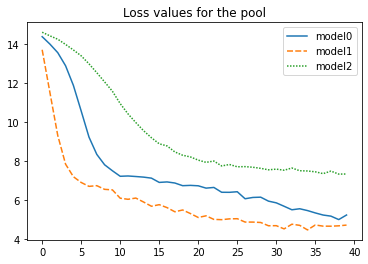

List of accuracies:  [tensor(0.8367), tensor(0.8467), tensor(0.8067)]


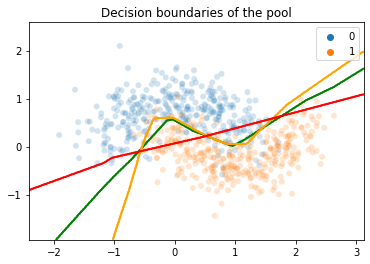

In [50]:
#################### define the classifier pool
# clf1
class Classifier1(nn.Module):
  def __init__(self, n_hidden=10, p_dropout=0.1):
        super(Classifier1, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(X_train.shape[1], n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 20),
            nn.ReLU(),
            nn.Linear(20, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
            )
        
  def forward(self, x):
    return torch.sigmoid(self.network(x))

# clf2
class Classifier2(nn.Module):
  def __init__(self, n_hidden=50, p_dropout=0.1):
        super(Classifier2, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(X_train.shape[1], n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
            )
        
  def forward(self, x):
    return torch.sigmoid(self.network(x))

# optimizers, criteria
clf1 = Classifier1()
clf2 = Classifier2()
clf3 = Classifier2( n_hidden=5)
clf1_criterion = nn.BCELoss()
clf2_criterion = nn.BCELoss()
clf3_criterion = nn.BCELoss()
clf1_optimizer = optim.Adam(clf1.parameters())
clf2_optimizer = optim.Adam(clf2.parameters())
clf3_optimizer = optim.Adam(clf3.parameters())

# pool
classifier_pool = [clf1, clf2, clf3]
criterion_pool = [clf1_criterion, clf2_criterion, clf3_criterion]
optimizer_pool = [clf1_optimizer, clf2_optimizer, clf3_optimizer]

#################### train the pool

# train one clf
def train_nn(clf, optimizer, criterion):
  total_loss = 0
  for x, y in train_loader:
    clf.zero_grad()
    p_y = clf(x)
    loss = criterion(p_y, y)
    total_loss += loss
    loss.backward()
    optimizer.step()
  return total_loss
    
### parameters
N_EPOCHS = 40

# train the pool
loss_evolution = np.zeros((N_EPOCHS, len(classifier_pool)))
for epoch in range(N_EPOCHS):
  if epoch%10 == 0:
    print('epoch %i'%epoch)
  for i_model in range(len(classifier_pool)):
    model = classifier_pool[i_model]
    optimizer = optimizer_pool[i_model]
    criterion = criterion_pool[i_model]
    loss_evolution[epoch, i_model] = train_nn(model, optimizer, criterion)

# plot loss evolution
sns.lineplot(data=pd.DataFrame(loss_evolution, columns=['model'+str(i) for i in range(len(classifier_pool))]))
plt.title(label='Loss values for the pool')
plt.show()

### Print test accuracy
acc = []
for model in classifier_pool:
  acc_model = 0
  for x, y in test_loader:
    y_pred = (model(x) >= 0.5).int() # à changer pour multiclasse
    acc_model += (y_pred == y).sum()
  acc.append(acc_model / X_test.shape[0])  
print('List of accuracies: ', acc)

plot_contour_pool(classifier_pool, torch.from_numpy(X_train), y_train)

### Modèle génératif: tentative avec réseaux de neurones

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90


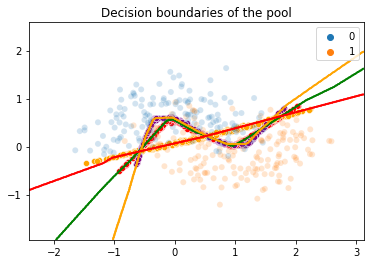

In [57]:
# Architecture

class DiscGen(nn.Module):
  def __init__(self, n_hidden=50, p_dropout=0.1):
        super(DiscGen, self).__init__()
        self.n_touchpoints = len(classifier_pool)
        self.network = nn.Sequential(
            nn.Linear(X_train.shape[1], n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, self.n_touchpoints * X_train.shape[1])
            )

  def forward(self, x):
    out = self.network(x).view(-1, self.n_touchpoints, X_train.shape[1])
    touchpoints_list = [out[:, i, :] for i in range(self.n_touchpoints)]
    return touchpoints_list

gen = DiscGen()
reconstruction_criterion = nn.MSELoss(reduction='sum')#reduction='sum')
gen_optimizer = optim.Adam(gen.parameters())


# train the thing
def train_gen(hyperparameters):
  K_DISC, K_ALIGN = hyperparameters
  total_loss = 0
  for x, y in train_loader:
    gen.zero_grad()
    touchpoints_list = gen(x) # on veut générer 1 touchpoint par frontière? Pas sûr. On peut peut-être générer les plus extrêmes directement ? Pas sûr.

    proximity_loss = (1.0 / len(touchpoints_list)) * sum([reconstruction_criterion(tp_i, x) for tp_i in touchpoints_list]) #vont tous chercher à être indépendamment proches de x
    #proximity_loss = min([reconstruction_criterion(tp_i, x) for tp_i in touchpoints_list]) # le plus proche point de discrepancy est vraiment proche. Les autres seront positionnés par rapport à celui là

    discrepancy_loss = (1.0 / len(touchpoints_list)) * sum([(classifier_pool[i](touchpoints_list[i]) - 0.5)**2 for i in range(len(touchpoints_list))]) # chaque touchpoint sur une frontière
    # Il faudrait qqc qui check que entre les deux c'est bien une zone de discrepancy - ok mais generalisation = ? 

    cos = torch.nn.CosineSimilarity()
    alignment_loss =  (1.0 / len(touchpoints_list)**2) * sum([1 - cos(tp_i - x, tp_j - x).abs() for tp_i in touchpoints_list for tp_j in touchpoints_list]) # minimisé si les points sont alignés
    
    # Et il faudrait dire aussi qu'ils ne croisent pas de frontiere probablement ? ...? On n'a pas de garantie entre les points là...

    loss =  proximity_loss + K_DISC * discrepancy_loss #-  K_ALIGN * alignment_loss

    total_loss += loss
    loss.sum().backward()
    gen_optimizer.step()
  # print(total_loss)



### parameters
N_EPOCHS = 100
K_DISC = 1000.0
K_ALIGN = 1.0

# train both clf:
for epoch in range(N_EPOCHS):
  if epoch%10 == 0:
    print('epoch %i'%epoch)
  train_gen(hyperparameters=(K_DISC, K_ALIGN))

# visualize learned discrepancies and calculate discrepancy score
discrepancy_score = 0
for x, _ in test_loader:
  touchpoints_list = gen(x)
  #discrepancy_score += reconstruction_criterion(tp1, tp2)
  tp1, tp2, tp3 = touchpoints_list
  sns.scatterplot(x=tp1.detach()[:,0], y=tp1.detach()[:, 1], color='red')
  sns.scatterplot(x=tp2.detach()[:,0], y=tp2.detach()[:, 1], color='purple')
  sns.scatterplot(x=tp3.detach()[:,0], y=tp3.detach()[:, 1], color='orange')
plot_contour_pool(classifier_pool, torch.from_numpy(X_test), y_test)
#print("Discrepancy score: ", discrepancy_score / X_test.shape[0])

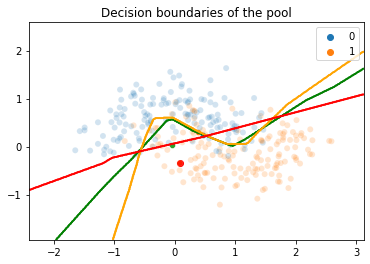

In [59]:
# une obs en particulier
for x, _ in test_loader:
  x = x[0]
  touchpoints_list = gen(x)
  print
  plt.scatter(x=x.detach().numpy()[0], y=x.detach().numpy()[1], color='red')
  for tp in touchpoints_list:
    sns.scatterplot(x=tp.detach()[:,0], y=tp.detach()[:, 1])

  break
plot_contour_pool(classifier_pool, torch.from_numpy(X_test), y_test)